In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def gaussian(a, m, sigma, x):
    return a*np.exp(-((x-m)/sigma)**2)

In [79]:
def random_potential(a, m, sigma, x):
    pot = 0.
    pot = -sum(gaussian(ai, mi, si, x) for ai, mi, si in zip(a,m, sigma))
    return pot


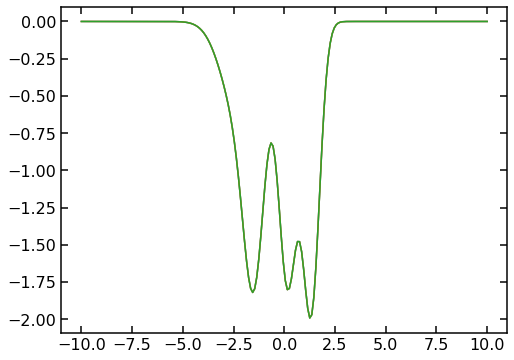

In [127]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
plt.figure(figsize=(8,6))
x = np.linspace(-10,10,200)
n_examples = 3
n_gaussians = 4

a = 2*np.random.random(n_gaussians)
m = 5*np.random.random(n_gaussians) - 2.5
sigma = np.random.random(n_gaussians) + .5


for i in range(n_examples):
    y = random_potential(a, m, sigma, x)
    plt.plot(x, y)

In [81]:
from _ham import Hamiltonian

In [6]:
# Inititalize Hamiltonian
length = 20
n_steps = 201
ham_random  = Hamiltonian(length,201)

In [7]:
n_gaussians = 4



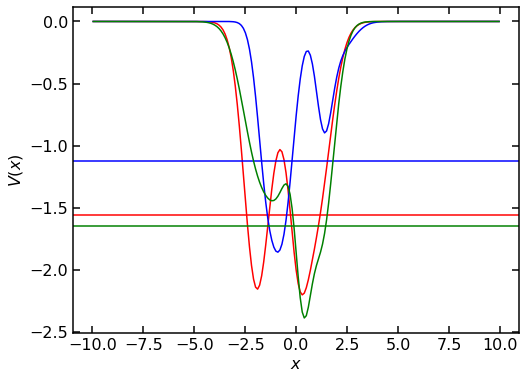

In [134]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
plt.figure(figsize=(8,6))

colors = ['red', 'blue', 'green']

for i in range(3):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5


    potential = lambda x: random_potential(a, m, sigma, x)
    ham_random.build_hamiltonian(potential)
    ham_random.diagonalize()
    plt.axhline(ham_random.eigvals[0], color=colors[i])

    plt.plot(ham_random.x_values, potential(ham_random.x_values),
            color=colors[i])

plt.xlabel('$x$'), plt.ylabel('$V(x)$')
# plt.ylim(0,10)
# plt.xlim(-8,8)

plt.show()
